# 2020 US Democrats

In [6]:
from my_weapon import *
from SQLite_handler import *
plt.style.use('fivethirtyeight')

In [7]:
%ll disk/users-face/

total 991052
-rw-rw-r-- 1 alex    192254 Mar  1 07:17 2020-02-14-2020-02-24-error.lj
-rw-rw-r-- 1 alex    327999 Mar  1 07:17 2020-02-14-2020-02-24.lj
-rw-rw-r-- 1 alex   8921088 Feb 25 01:04 2020-02-15-error.lj
-rw-rw-r-- 1 alex    423450 Mar  1 12:09 2020-02-24-2020-02-28-error.lj
-rw-rw-r-- 1 alex  32852500 Mar  1 12:09 2020-02-24-2020-02-28.lj
-rw-rw-r-- 1 alex      3539 Mar  2 04:27 2020-02-28-2020-02-29-error.lj
-rw-rw-r-- 1 alex    746606 Mar  2 04:27 2020-02-28-2020-02-29.lj
-rw-rw-r-- 1 alex 268276138 Mar  2 04:11 2020-02-28.lj
-rw-rw-r-- 1 alex     38258 Mar  2 05:19 2020-02-29-2020-03-01-error.lj
-rw-rw-r-- 1 alex   6023058 Mar  2 05:19 2020-02-29-2020-03-01.lj
-rw-rw-r-- 1 alex     61255 Mar  6 07:50 2020-03-01-2020-03-02-error.lj
-rw-rw-r-- 1 alex         0 Mar  6 07:48 2020-03-01-2020-03-02.lj
-rw-rw-r-- 1 alex  10996639 Mar  2 07:02 2020-03-02.csv
-rw-rw-r-- 1 alex     96877 Mar  6 11:09 2020-03-05-2020-03-06-error.lj
-rw-rw-r-- 1 alex  24925846 Mar  6 11:09 2020-03-05-2

## Loading faces

In [8]:
# users = []

# for line in tqdm(open("disk/users-face/2020-02-24.lj")):
#     d = json.loads(line.strip())
#     face = d["faces"][0]
#     # print(face)
#     age = face['attributes']["age"]["value"]
#     gender = face['attributes']["gender"]["value"]

#     if age < 18:
#         continue
#     elif age >= 18 and age < 30:
#         age_range = ">=18, <30"
#     elif age >= 30 and age < 50:
#         age_range = ">=30, <50"
#     elif age >= 50 and age < 65:
#         age_range = ">=50, <65"
#     elif age >= 65:
#         age_range = ">=65"

#     users.append({"uid": d["id"], 
#                   "age": age, 
#                   "gender": gender, 
#                   "age_range": age_range}
#                 )
        
# users = pd.DataFrame(users).set_index("uid")
# users = users[~users.index.duplicated(keep='first')]

users = pd.read_csv("disk/users-face/2020-03-02.csv").set_index("uid")
users

,age,gender,age_range
uid,,,
15715866,30,Male,">=30, <50"
1230079565231468544,47,Female,">=30, <50"
25758126,32,Female,">=30, <50"
2400557966,25,Male,">=18, <30"
2821590472,55,Male,">=50, <65"
...,...,...,...
82088390,23,Male,">=18, <30"
1212289660589764608,34,Female,">=30, <50"
305613459,24,Male,">=18, <30"


FileNotFoundError: [Errno 2] No such file or directory: '../Argentina_election/web/static/us2020_twitter_population_0302.png'

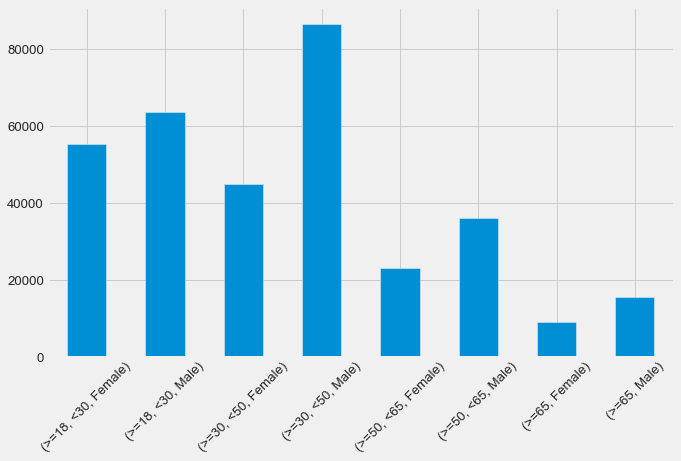

In [9]:
groups = users.groupby(["age_range", "gender"]).size()
groups

sns.set(style="darkgrid", font_scale=1.2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
groups.plot.bar()
plt.xlabel("")
plt.xticks(rotation=45)
plt.savefig("../Argentina_election/web/static/us2020_twitter_population_0302.png",
            bbox_inches = 'tight', dpi=300)

In [ ]:
m_18, f_18 = 0, 0
m_30, f_30 = 0, 0
m_50, f_50 = 0, 0
m_65, f_65 = 0, 0

for row in tqdm(users.itertuples()):
    if row.gender == "Male":
        if row.age >= 18 and row.age < 30:
            m_18 += 1
        elif row.age >= 30 and row.age < 50:
            m_30 += 1
        elif row.age >= 50 and row.age < 65:
            m_50 += 1
        elif row.age >= 65:
            m_65 += 1
    elif row.gender == "Female":
        if row.age >= 18 and row.age < 30:
            f_18 += 1
        elif row.age >= 30 and row.age < 50:
            f_30 += 1
        elif row.age >= 50 and row.age < 65:
            f_50 += 1
        elif row.age >= 65:
            f_65 += 1
            
age_gender_dist = {
    "category": [
        "female 18-29", "male 18-29", 
        "female 30-49", "male 30-49", 
        "female 50-64", "male 50-64", 
        "female >=65", "male >=65",
    ],
    "n": [
              f_18, m_18, 
              f_30, m_30, 
              f_50, m_50, 
              f_65, m_65,
         ]
}
age_gender_dist = pd.DataFrame(age_gender_dist).set_index("category")
age_gender_dist["percent"] = age_gender_dist / age_gender_dist.sum()

## Census

In [10]:
data = pd.read_csv("data/US_age_sex.csv")
data

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTBASE2010_CIV,POPEST2010_CIV,POPEST2011_CIV,POPEST2012_CIV,POPEST2013_CIV,POPEST2014_CIV,POPEST2015_CIV,POPEST2016_CIV,POPEST2017_CIV,POPEST2018_CIV
0,10,0,0,0,United States,0,0,3944160,3951430,3963092,3926570,3931258,3954786,3983965,3955192,3893945,3848208
1,10,0,0,0,United States,0,1,3978090,3957730,3966225,3977550,3942696,3948892,3973192,4003594,3973803,3912900
2,10,0,0,0,United States,0,2,4096939,4090621,3970654,3978924,3991745,3958708,3966330,3991543,4020825,3991437
3,10,0,0,0,United States,0,3,4119051,4111688,4101644,3981532,3991019,4005932,3974354,3982719,4006802,4036562
4,10,0,0,0,United States,0,4,4063186,4077346,4121488,4111490,3992496,4004035,4020264,3989317,3996592,4021168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,40,4,8,56,Wyoming,2,82,1103,1103,1107,1084,1106,1105,1035,1090,1134,1122
13568,40,4,8,56,Wyoming,2,83,911,936,1028,1035,1002,1030,1031,953,1026,1057
13569,40,4,8,56,Wyoming,2,84,894,883,880,1011,988,945,973,974,919,985
13570,40,4,8,56,Wyoming,2,85,5624,5644,5730,5853,6051,6257,6368,6535,6672,6680


In [11]:
data.NAME.unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [12]:
for state in data.NAME.unique():
    print(state)
    cen = data[data["NAME"]==state]
    cen = {
        "category": ["female 18-29",
                     "male 18-29", 
                     "female 30-49",
                     "male 30-49", 
                     "female 50-64",
                     "male 50-64", 
                     "female >=65", 
                     "male >=65", ],
        "n": [
              sum(cen[(cen.SEX == 2) & (cen.AGE >= 18) & (cen.AGE < 30)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 1) & (cen.AGE >= 18) & (cen.AGE < 30)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 2) & (cen.AGE >= 30) & (cen.AGE < 50)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 1) & (cen.AGE >= 30) & (cen.AGE < 50)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 2) & (cen.AGE >= 50) & (cen.AGE < 65)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 1) & (cen.AGE >= 50) & (cen.AGE < 65)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 2) & (cen.AGE >= 65) & (cen.AGE < 100)]["POPEST2018_CIV"]),
              sum(cen[(cen.SEX == 1) & (cen.AGE >= 65) & (cen.AGE < 100)]["POPEST2018_CIV"]),
            ]
    }
    cen = pd.DataFrame(cen).set_index("category")
    cen["percent"] = cen / cen.sum()
#     cen
    cen.to_csv(f"data/census/{state}.csv")
    
    plt.figure(figsize=(10, 6))
    cen["percent"].plot.bar()
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.title(f"Distribution of population from Census ({state})")
    #plt.savefig(f"fig/us_census_{state}.png", dpi=300, bbox_inches = 'tight')
    plt.close()

United States
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


In [ ]:
num2label = {
     0: "Pete Buttigieg", 
     1: "Bernie Sanders", 
     2: "Elizabeth Warren", 
     3: "Joe Biden", 
     4: "Others",
     5: "Mike Bloomberg"
}

def making_pickle_file(csv_file, pickle_file):
    users = pd.read_csv(csv_file).set_index("uid").T.to_dict()
    _users = []
    for u, v in users.items():
        _v = np.array([v["0"], v["1"], v["2"], v["3"], v["4"], v["5"]])
#         _v = np.array([v["0"], v["1"], v["2"], v["3"], v["4"]])
        camp = num2label[_v.argmax()]
        _users.append({
            "uid": u,
            "Camp": camp
        })
    print("# of users:", len(_users))
    pd.DataFrame(_users).set_index("uid").to_pickle(pickle_file)

for i in tqdm(range(1, 181)):
    if i % 3 == 0:
        making_pickle_file(f"disk/users-To2020-02-29/{i}.csv",
                           f"data/users_pickle_mat/To2020-02-29-{i}.pl")

In [ ]:
######################################
#################################
#####Matteo
num2label = {
     0: "Pete Buttigieg", 
     1: "Bernie Sanders", 
     2: "Elizabeth Warren", 
     3: "Joe Biden", 
     4: "Others",
     5: "Mike Bloomberg"
}

def making_pickle_file(csv_file, pickle_file):
    users = pd.read_csv(csv_file).set_index("uid").T.to_dict()
    _users = []
    for u, v in users.items():
        _v = np.array([v["0"], v["1"], v["2"], v["3"], v["4"], v["5"]])
#         _v = np.array([v["0"], v["1"], v["2"], v["3"], v["4"]])
        camp = num2label[_v.argmax()]
        _users.append({
            "uid": u,
            "Camp": camp
        })
    print("# of users:", len(_users))
    pd.DataFrame(_users).set_index("uid").to_pickle(pickle_file)

#for i in tqdm(range(1, 181)):
#    if i % 2 == 0:
#        making_pickle_file(f"disk/users-To2020-02-29/{i}.csv",
#                           f"data/users_pickle_mat/To2020-02-29-{i}.pl")

In [ ]:
# making_pickle_file("disk/users-14days/2020-02-11.csv",
#                    "disk/users-pickle/14days-2020-02-11.pl")

# making_pickle_file("disk/users-14days/2020-02-22.csv",
#                    "disk/users-pickle/14days-2020-02-22.pl")

#making_pickle_file("disk/users-14days/2020-02-24.csv",
#                   "disk/users-pickle/14days-2020-02-24.pl")


In [ ]:
# join the opinions
# users_opinion = pd.read_pickle("disk/users-pickle/14days-2020-02-03.pl")
users_opinion = pd.read_pickle("disk/users-pickle/To2020-02-29-60.pl")
users_opinion

In [ ]:
print("N of classified users:", len(users_opinion))
print("% of users supporting BS:", float(users_opinion[users_opinion["Camp"] == "Bernie Sanders"].count() / users_opinion.count()) * 100)

In [ ]:
users_v2 = users.join(users_opinion, how="inner")
print(users_v2)
print("N of classified users with age, gender:", len(users_v2))
print("% of users supporting Clinton:", len(users_v2[users_v2["Camp"] == "Bernie Sanders"]) / len(users_v2) * 100)
print("% of users supporting Others:", len(users_v2[users_v2["Camp"] == "Others"]) / len(users_v2) * 100)

In [ ]:
groups = users_v2.groupby(["age_range", "gender", "Camp"]).size()
groups

In [ ]:
colors = [
'#7cb5ec', '#434348', '#90ed7d', '#f7a35c', '#8085e9', 
]

sns.set(style="darkgrid", font_scale=1.5)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 6))
groups.plot.bar(color=colors)
plt.xlabel("")
plt.savefig("../Argentina_election/web/static/US2020_age_gender_0302.png", bbox_inches = 'tight', dpi=300)

# Add location (states)

In [ ]:
users = pd.read_csv("disk/users-face/2020-03-02.csv").set_index("uid")
users_state = pd.read_csv("disk/users-location/2020-03-02.csv", 
                          usecols=["uid","state"],
                          error_bad_lines=False).set_index("uid")
users_state_gender_age = users.join(users_state, how="inner")
set_users = set(users_state_gender_age.index)

In [ ]:
users_v3 = users_v2.join(users_state, how="inner")
users_v3

In [ ]:
states = ['CA', 'TX', 'NY', 'FL', 'IL', 'GA', 'PA', 'OH', 'DC', 'NC', 'MI', 'MA',
       'IN', 'NJ', 'VA', 'AZ', 'TN', 'WA', 'MD', 'CO', 'MO', 'KY', 'LA', 'MN',
       'OR', 'AL', 'SC', 'NV', 'OK', 'WI', 'IA', 'CT', 'KS', 'AR', 'UT', 'MS',
       'WV', 'NE', 'NM', 'HI', 'NH', 'RI', 'ME', 'ID', 'AK', 'DE', 'MT', 'SD',
       'ND', 'VT', 'WY']

In [ ]:
users_v3.Camp.value_counts()

In [ ]:
users_tmp = users_v3[users_v3.state=="NV"]

In [ ]:
users_tmp.Camp.value_counts()

In [ ]:
groups = users_tmp.groupby(["age_range", "gender", "Camp"]).size()
groups

In [ ]:
colors = [
'#7cb5ec', '#434348', '#90ed7d', '#f7a35c', '#8085e9', '#f15c80', 
]
sns.set(style="darkgrid", font_scale=1.5)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 6))
groups.plot.bar(color=colors)
plt.xlabel("")
plt.savefig("../Argentina_election/web/static/US2020_age_gender_NV_0222.png", bbox_inches = 'tight', dpi=300)

In [ ]:
sns.set(style="darkgrid", font_scale=1.5)
plt.style.use('fivethirtyeight')

for _state in states:
    # print(_state)
    users_tmp = users_v3[users_v3.state==_state]
    colors = [
        '#7cb5ec', '#434348', '#90ed7d', '#f7a35c', '#8085e9', '#f15c80', 
    ]
    groups = users_tmp.groupby(["age_range", "gender", "Camp"]).size()
    plt.figure(figsize=(18, 6))
    groups.plot.bar(color=colors)
    plt.xlabel("")
    plt.savefig(f"../Argentina_election/web/static/US2020_age_gender_{_state}_0222.png", 
                bbox_inches = 'tight')
    plt.close()

In [ ]:
num2label = {
    # 0: "Pete Buttigieg", #remove pete
     1: "Bernie Sanders", 
     2: "Elizabeth Warren", 
     3: "Joe Biden",
     4: "Others",
     5: "Mike Bloomberg"
}

def making_json_file_v2(csv_file, json_file):
    users = pd.read_csv(csv_file).set_index("uid")
    _users = []
    for u, row in users.iterrows():
        if u in set_users:
            _v = np.array(row)
            max_i = _v.argmax()
            if max_i == 0: # remove pete
                _v[0] = -1
                max_i = _v.argmax()

            camp = num2label[max_i]
            _users.append({
                "uid": u,
                "Camp": camp
            })
    print("# of users:", len(_users))
    users = pd.DataFrame(_users).set_index("uid").join(users_state_gender_age, how="inner")
    users.to_json(json_file)

In [ ]:
for i in range(160, 121, -5):
    print(i)
    making_json_file_v2(f"data/Cumulatives_BT/170/{i}.csv",
                        f"data/users-pickle/To2020-02-29-{i}.json")

In [83]:
import us
dict_names = us.states.mapping('abbr', 'name')

def rescale_opinion(input_users, state_name):
    if state_name == "US":
        cen = pd.read_csv(f"data/census/US.csv").set_index("category")
    else:
        cen = pd.read_csv(f"data/census/{dict_names[state_name]}.csv").set_index("category")
    # print("After reweighting!")
    w = cen.percent.to_list()
    
    camps = [
         "Bernie Sanders", 
         "Joe Biden",
         #"Elizabeth Warren", 
         #"Mike Bloomberg",
         #"Pete Buttigieg",
         "Others",
    ]
    # print(input_users)
    
    if state_name == "US":
        users_tmp = input_users
    else:
        print('here')
        users_tmp = input_users[input_users.state==state_name]
        
    groups = users_tmp.groupby(["age_range", "gender", "Camp"]).size()
    # print(groups)
    _rst = {}

    for _camp in camps:
        r = groups[">=18, <30"]["Female"].get(_camp, 0) / sum(groups[">=18, <30"]["Female"]) * w[0] \
        + groups[">=18, <30"]["Male"].get(_camp, 0) / sum(groups[">=18, <30"]["Male"]) * w[1] \
        + groups[">=30, <50"]["Female"].get(_camp, 0) / sum(groups[">=30, <50"]["Female"]) * w[2] \
        + groups[">=30, <50"]["Male"].get(_camp, 0) / sum(groups[">=30, <50"]["Male"]) * w[3] \
        + groups[">=50, <65"]["Female"].get(_camp, 0) / sum(groups[">=50, <65"]["Female"]) * w[4] \
        + groups[">=50, <65"]["Male"].get(_camp, 0) / sum(groups[">=50, <65"]["Male"]) * w[5] \
        + groups[">=65"]["Female"].get(_camp, 0) / sum(groups[">=65"]["Female"]) * w[6] \
        + groups[">=65"]["Male"].get(_camp, 0) / sum(groups[">=65"]["Male"]) * w[7]
        # print(_camp, round(r, 3))
        _rst[_camp] = round(r * 100, 1)
        
    return _rst

In [92]:
import ujson as json
import us
#SuperTuesday = ['CA', 'TX', 'NY', 'FL', 'IL', 'GA', 'PA', 'OH', 'DC', 'NC', 'MI', 'MA',
 #     'IN', 'NJ', 'VA', 'AZ', 'TN', 'WA', 'MD', 'CO', 'MO', 'KY', 'LA', 'MN',
 #      'OR', 'AL', 'SC', 'NV', 'OK', 'WI', 'IA', 'CT', 'KS', 'AR', 'UT', 'MS',
 #     'WV', 'NE', 'NM', 'HI', 'NH', 'RI', 'ME', 'ID', 'AK', 'DE', 'MT', 'SD',
 #     'ND', 'VT', 'WY']
#                ["AL", "AR", "CA", "CO",
 #               "ME", "MA", "MN", "NC", "OK",
 #               "TN", "TX", "UT", "VT", "VA"]

SuperTuesday = ["ID", "MI", "MS", "MO", "WA"] # 170
rsts = []
# dt = pendulum.date(2020, 2, 29)
start = pendulum.datetime(2019, 9,15, tz="UTC")
end = pendulum.datetime(2020, 3, 11, tz="UTC")
i=1
#for dt in tqdm(pendulum.period(start, end)):
for i in range(178):
    dt_str = dt.to_date_string()
    print(dt_str)
    #if dt_str == "2020-03-02":
    if dt_str != "2020-05-02":
        # print(dt_str)
        #input_users = pd.read_csv(f"disk/users-To2020-03-10/{dt_str}.csv").set_index("uid")
        input_users = pd.read_csv(f"disk/users-To2020-03-10/{i+2}.csv").set_index("uid")
        # print(input_users)
        
        for k, v in dict_names.items():
            if k in SuperTuesday:
                # print(k)
                rst = rescale_opinion(input_users, k)
                rst["state"] = k
                #rst["dt"] = dt_str
                rst["dt"] = i+2
                print(rst)
                rsts.append(rst)
                
rsts = pd.DataFrame(rsts).set_index("dt")
rsts = rsts.sort_index()
rsts.to_csv("data/csv/10_March_m2_Tnote.csv")

2020-02-21
here
{'Bernie Sanders': 36.1, 'Joe Biden': 59.5, 'Others': 4.3, 'state': 'ID', 'dt': 2}
here
{'Bernie Sanders': 41.5, 'Joe Biden': 53.8, 'Others': 4.7, 'state': 'MI', 'dt': 2}
here
{'Bernie Sanders': 42.6, 'Joe Biden': 50.8, 'Others': 6.6, 'state': 'MS', 'dt': 2}
here
{'Bernie Sanders': 39.5, 'Joe Biden': 55.9, 'Others': 4.5, 'state': 'MO', 'dt': 2}
here
{'Bernie Sanders': 44.7, 'Joe Biden': 50.9, 'Others': 4.4, 'state': 'WA', 'dt': 2}
2020-02-21
here
{'Bernie Sanders': 40.9, 'Joe Biden': 52.8, 'Others': 6.3, 'state': 'ID', 'dt': 3}
here
{'Bernie Sanders': 42.8, 'Joe Biden': 52.1, 'Others': 5.1, 'state': 'MI', 'dt': 3}
here
{'Bernie Sanders': 46.0, 'Joe Biden': 47.0, 'Others': 6.9, 'state': 'MS', 'dt': 3}
here
{'Bernie Sanders': 39.1, 'Joe Biden': 54.6, 'Others': 6.3, 'state': 'MO', 'dt': 3}
here
{'Bernie Sanders': 48.3, 'Joe Biden': 47.0, 'Others': 4.7, 'state': 'WA', 'dt': 3}
2020-02-21
here
{'Bernie Sanders': 40.9, 'Joe Biden': 53.8, 'Others': 5.3, 'state': 'ID', 'dt': 4}

{'Bernie Sanders': 51.8, 'Joe Biden': 41.4, 'Others': 6.8, 'state': 'WA', 'dt': 20}
2020-02-21
here
{'Bernie Sanders': 45.1, 'Joe Biden': 49.6, 'Others': 5.3, 'state': 'ID', 'dt': 21}
here
{'Bernie Sanders': 47.6, 'Joe Biden': 46.2, 'Others': 6.2, 'state': 'MI', 'dt': 21}
here
{'Bernie Sanders': 42.7, 'Joe Biden': 50.5, 'Others': 6.8, 'state': 'MS', 'dt': 21}
here
{'Bernie Sanders': 43.7, 'Joe Biden': 48.7, 'Others': 7.6, 'state': 'MO', 'dt': 21}
here
{'Bernie Sanders': 51.9, 'Joe Biden': 41.2, 'Others': 6.8, 'state': 'WA', 'dt': 21}
2020-02-21
here
{'Bernie Sanders': 44.3, 'Joe Biden': 49.4, 'Others': 6.2, 'state': 'ID', 'dt': 22}
here
{'Bernie Sanders': 47.6, 'Joe Biden': 46.0, 'Others': 6.4, 'state': 'MI', 'dt': 22}
here
{'Bernie Sanders': 43.1, 'Joe Biden': 50.2, 'Others': 6.7, 'state': 'MS', 'dt': 22}
here
{'Bernie Sanders': 43.8, 'Joe Biden': 48.5, 'Others': 7.7, 'state': 'MO', 'dt': 22}
here
{'Bernie Sanders': 52.2, 'Joe Biden': 40.7, 'Others': 7.1, 'state': 'WA', 'dt': 22}
2020

{'Bernie Sanders': 51.6, 'Joe Biden': 41.4, 'Others': 7.0, 'state': 'WA', 'dt': 38}
2020-02-21
here
{'Bernie Sanders': 43.9, 'Joe Biden': 50.1, 'Others': 6.0, 'state': 'ID', 'dt': 39}
here
{'Bernie Sanders': 46.5, 'Joe Biden': 47.1, 'Others': 6.4, 'state': 'MI', 'dt': 39}
here
{'Bernie Sanders': 40.8, 'Joe Biden': 51.6, 'Others': 7.6, 'state': 'MS', 'dt': 39}
here
{'Bernie Sanders': 43.3, 'Joe Biden': 48.7, 'Others': 8.0, 'state': 'MO', 'dt': 39}
here
{'Bernie Sanders': 51.6, 'Joe Biden': 41.4, 'Others': 7.0, 'state': 'WA', 'dt': 39}
2020-02-21
here
{'Bernie Sanders': 43.8, 'Joe Biden': 50.3, 'Others': 6.0, 'state': 'ID', 'dt': 40}
here
{'Bernie Sanders': 46.3, 'Joe Biden': 47.3, 'Others': 6.4, 'state': 'MI', 'dt': 40}
here
{'Bernie Sanders': 40.5, 'Joe Biden': 52.0, 'Others': 7.6, 'state': 'MS', 'dt': 40}
here
{'Bernie Sanders': 43.1, 'Joe Biden': 48.8, 'Others': 8.0, 'state': 'MO', 'dt': 40}
here
{'Bernie Sanders': 51.1, 'Joe Biden': 41.8, 'Others': 7.1, 'state': 'WA', 'dt': 40}
2020

{'Bernie Sanders': 50.5, 'Joe Biden': 42.6, 'Others': 7.0, 'state': 'WA', 'dt': 56}
2020-02-21
here
{'Bernie Sanders': 42.2, 'Joe Biden': 52.2, 'Others': 5.6, 'state': 'ID', 'dt': 57}
here
{'Bernie Sanders': 45.1, 'Joe Biden': 48.5, 'Others': 6.4, 'state': 'MI', 'dt': 57}
here
{'Bernie Sanders': 39.1, 'Joe Biden': 53.5, 'Others': 7.4, 'state': 'MS', 'dt': 57}
here
{'Bernie Sanders': 41.8, 'Joe Biden': 50.5, 'Others': 7.7, 'state': 'MO', 'dt': 57}
here
{'Bernie Sanders': 50.5, 'Joe Biden': 42.5, 'Others': 7.0, 'state': 'WA', 'dt': 57}
2020-02-21
here
{'Bernie Sanders': 42.2, 'Joe Biden': 52.2, 'Others': 5.6, 'state': 'ID', 'dt': 58}
here
{'Bernie Sanders': 45.1, 'Joe Biden': 48.5, 'Others': 6.4, 'state': 'MI', 'dt': 58}
here
{'Bernie Sanders': 39.1, 'Joe Biden': 53.5, 'Others': 7.4, 'state': 'MS', 'dt': 58}
here
{'Bernie Sanders': 41.8, 'Joe Biden': 50.5, 'Others': 7.7, 'state': 'MO', 'dt': 58}
here
{'Bernie Sanders': 50.5, 'Joe Biden': 42.5, 'Others': 7.0, 'state': 'WA', 'dt': 58}
2020

{'Bernie Sanders': 50.7, 'Joe Biden': 42.4, 'Others': 6.9, 'state': 'WA', 'dt': 74}
2020-02-21
here
{'Bernie Sanders': 41.1, 'Joe Biden': 53.1, 'Others': 5.7, 'state': 'ID', 'dt': 75}
here
{'Bernie Sanders': 44.6, 'Joe Biden': 49.0, 'Others': 6.4, 'state': 'MI', 'dt': 75}
here
{'Bernie Sanders': 37.1, 'Joe Biden': 55.3, 'Others': 7.5, 'state': 'MS', 'dt': 75}
here
{'Bernie Sanders': 41.2, 'Joe Biden': 51.3, 'Others': 7.6, 'state': 'MO', 'dt': 75}
here
{'Bernie Sanders': 50.6, 'Joe Biden': 42.5, 'Others': 6.9, 'state': 'WA', 'dt': 75}
2020-02-21
here
{'Bernie Sanders': 41.1, 'Joe Biden': 53.1, 'Others': 5.7, 'state': 'ID', 'dt': 76}
here
{'Bernie Sanders': 44.6, 'Joe Biden': 49.0, 'Others': 6.4, 'state': 'MI', 'dt': 76}
here
{'Bernie Sanders': 37.1, 'Joe Biden': 55.3, 'Others': 7.5, 'state': 'MS', 'dt': 76}
here
{'Bernie Sanders': 41.3, 'Joe Biden': 51.2, 'Others': 7.6, 'state': 'MO', 'dt': 76}
here
{'Bernie Sanders': 50.5, 'Joe Biden': 42.6, 'Others': 6.9, 'state': 'WA', 'dt': 76}
2020

{'Bernie Sanders': 48.8, 'Joe Biden': 43.9, 'Others': 7.3, 'state': 'WA', 'dt': 92}
2020-02-21
here
{'Bernie Sanders': 41.4, 'Joe Biden': 52.9, 'Others': 5.7, 'state': 'ID', 'dt': 93}
here
{'Bernie Sanders': 44.0, 'Joe Biden': 49.5, 'Others': 6.5, 'state': 'MI', 'dt': 93}
here
{'Bernie Sanders': 36.4, 'Joe Biden': 55.5, 'Others': 8.2, 'state': 'MS', 'dt': 93}
here
{'Bernie Sanders': 40.6, 'Joe Biden': 51.9, 'Others': 7.5, 'state': 'MO', 'dt': 93}
here
{'Bernie Sanders': 48.9, 'Joe Biden': 43.8, 'Others': 7.3, 'state': 'WA', 'dt': 93}
2020-02-21
here
{'Bernie Sanders': 41.5, 'Joe Biden': 52.9, 'Others': 5.5, 'state': 'ID', 'dt': 94}
here
{'Bernie Sanders': 43.8, 'Joe Biden': 49.7, 'Others': 6.5, 'state': 'MI', 'dt': 94}
here
{'Bernie Sanders': 36.2, 'Joe Biden': 55.6, 'Others': 8.2, 'state': 'MS', 'dt': 94}
here
{'Bernie Sanders': 40.5, 'Joe Biden': 52.1, 'Others': 7.4, 'state': 'MO', 'dt': 94}
here
{'Bernie Sanders': 48.7, 'Joe Biden': 44.0, 'Others': 7.3, 'state': 'WA', 'dt': 94}
2020

{'Bernie Sanders': 39.1, 'Joe Biden': 53.9, 'Others': 7.1, 'state': 'MO', 'dt': 111}
here
{'Bernie Sanders': 47.6, 'Joe Biden': 45.1, 'Others': 7.3, 'state': 'WA', 'dt': 111}
2020-02-21
here
{'Bernie Sanders': 38.5, 'Joe Biden': 56.1, 'Others': 5.4, 'state': 'ID', 'dt': 112}
here
{'Bernie Sanders': 42.3, 'Joe Biden': 51.3, 'Others': 6.4, 'state': 'MI', 'dt': 112}
here
{'Bernie Sanders': 34.0, 'Joe Biden': 57.9, 'Others': 8.1, 'state': 'MS', 'dt': 112}
here
{'Bernie Sanders': 38.9, 'Joe Biden': 54.0, 'Others': 7.1, 'state': 'MO', 'dt': 112}
here
{'Bernie Sanders': 47.7, 'Joe Biden': 45.1, 'Others': 7.3, 'state': 'WA', 'dt': 112}
2020-02-21
here
{'Bernie Sanders': 38.0, 'Joe Biden': 56.5, 'Others': 5.4, 'state': 'ID', 'dt': 113}
here
{'Bernie Sanders': 42.5, 'Joe Biden': 51.2, 'Others': 6.4, 'state': 'MI', 'dt': 113}
here
{'Bernie Sanders': 34.2, 'Joe Biden': 57.7, 'Others': 8.1, 'state': 'MS', 'dt': 113}
here
{'Bernie Sanders': 39.0, 'Joe Biden': 53.8, 'Others': 7.2, 'state': 'MO', 'dt'

{'Bernie Sanders': 38.4, 'Joe Biden': 54.5, 'Others': 7.1, 'state': 'MO', 'dt': 129}
here
{'Bernie Sanders': 46.9, 'Joe Biden': 45.7, 'Others': 7.4, 'state': 'WA', 'dt': 129}
2020-02-21
here
{'Bernie Sanders': 37.0, 'Joe Biden': 57.6, 'Others': 5.4, 'state': 'ID', 'dt': 130}
here
{'Bernie Sanders': 42.1, 'Joe Biden': 51.5, 'Others': 6.4, 'state': 'MI', 'dt': 130}
here
{'Bernie Sanders': 33.9, 'Joe Biden': 58.6, 'Others': 7.5, 'state': 'MS', 'dt': 130}
here
{'Bernie Sanders': 38.3, 'Joe Biden': 54.6, 'Others': 7.1, 'state': 'MO', 'dt': 130}
here
{'Bernie Sanders': 47.1, 'Joe Biden': 45.5, 'Others': 7.4, 'state': 'WA', 'dt': 130}
2020-02-21
here
{'Bernie Sanders': 37.1, 'Joe Biden': 57.5, 'Others': 5.4, 'state': 'ID', 'dt': 131}
here
{'Bernie Sanders': 42.0, 'Joe Biden': 51.6, 'Others': 6.4, 'state': 'MI', 'dt': 131}
here
{'Bernie Sanders': 33.9, 'Joe Biden': 58.6, 'Others': 7.5, 'state': 'MS', 'dt': 131}
here
{'Bernie Sanders': 38.3, 'Joe Biden': 54.6, 'Others': 7.1, 'state': 'MO', 'dt'

{'Bernie Sanders': 38.1, 'Joe Biden': 54.9, 'Others': 7.0, 'state': 'MO', 'dt': 147}
here
{'Bernie Sanders': 46.5, 'Joe Biden': 46.0, 'Others': 7.6, 'state': 'WA', 'dt': 147}
2020-02-21
here
{'Bernie Sanders': 36.8, 'Joe Biden': 57.8, 'Others': 5.4, 'state': 'ID', 'dt': 148}
here
{'Bernie Sanders': 41.7, 'Joe Biden': 51.7, 'Others': 6.6, 'state': 'MI', 'dt': 148}
here
{'Bernie Sanders': 34.1, 'Joe Biden': 58.6, 'Others': 7.3, 'state': 'MS', 'dt': 148}
here
{'Bernie Sanders': 37.9, 'Joe Biden': 55.0, 'Others': 7.1, 'state': 'MO', 'dt': 148}
here
{'Bernie Sanders': 46.5, 'Joe Biden': 46.0, 'Others': 7.6, 'state': 'WA', 'dt': 148}
2020-02-21
here
{'Bernie Sanders': 36.8, 'Joe Biden': 57.8, 'Others': 5.4, 'state': 'ID', 'dt': 149}
here
{'Bernie Sanders': 41.7, 'Joe Biden': 51.7, 'Others': 6.6, 'state': 'MI', 'dt': 149}
here
{'Bernie Sanders': 34.1, 'Joe Biden': 58.6, 'Others': 7.3, 'state': 'MS', 'dt': 149}
here
{'Bernie Sanders': 37.9, 'Joe Biden': 55.1, 'Others': 7.0, 'state': 'MO', 'dt'

{'Bernie Sanders': 32.6, 'Joe Biden': 59.7, 'Others': 7.7, 'state': 'MS', 'dt': 165}
here
{'Bernie Sanders': 36.7, 'Joe Biden': 56.3, 'Others': 7.0, 'state': 'MO', 'dt': 165}
here
{'Bernie Sanders': 46.0, 'Joe Biden': 46.6, 'Others': 7.4, 'state': 'WA', 'dt': 165}
2020-02-21
here
{'Bernie Sanders': 36.8, 'Joe Biden': 57.6, 'Others': 5.6, 'state': 'ID', 'dt': 166}
here
{'Bernie Sanders': 40.9, 'Joe Biden': 52.6, 'Others': 6.5, 'state': 'MI', 'dt': 166}
here
{'Bernie Sanders': 32.6, 'Joe Biden': 59.7, 'Others': 7.7, 'state': 'MS', 'dt': 166}
here
{'Bernie Sanders': 36.7, 'Joe Biden': 56.3, 'Others': 7.0, 'state': 'MO', 'dt': 166}
here
{'Bernie Sanders': 46.0, 'Joe Biden': 46.6, 'Others': 7.4, 'state': 'WA', 'dt': 166}
2020-02-21
here
{'Bernie Sanders': 36.8, 'Joe Biden': 57.6, 'Others': 5.6, 'state': 'ID', 'dt': 167}
here
{'Bernie Sanders': 40.6, 'Joe Biden': 52.9, 'Others': 6.5, 'state': 'MI', 'dt': 167}
here
{'Bernie Sanders': 32.5, 'Joe Biden': 59.9, 'Others': 7.6, 'state': 'MS', 'dt'

In [ ]:
input_users

In [ ]:
############
#########
###Matteo
import ujson as json

SuperTuesday = ['CA', 'TX', 'NY', 'FL', 'IL', 'GA', 'PA', 'OH', 'DC', 'NC', 'MI', 'MA',
       'IN', 'NJ', 'VA', 'AZ', 'TN', 'WA', 'MD', 'CO', 'MO', 'KY', 'LA', 'MN',
       'OR', 'AL', 'SC', 'NV', 'OK', 'WI', 'IA', 'CT', 'KS', 'AR', 'UT', 'MS',
       'WV', 'NE', 'NM', 'HI', 'NH', 'RI', 'ME', 'ID', 'AK', 'DE', 'MT', 'SD',
       'ND', 'VT', 'WY']
#                ["AL", "AR", "CA", "CO",
 #               "ME", "MA", "MN", "NC", "OK",
 #               "TN", "TX", "UT", "VT", "VA"]

# SuperTuesday = ["AL", "CA", "CO", "ME", "TX", "UT", "VT", "VA"] # 170
rsts = []
# dt = pendulum.date(2020, 2, 29)
start = pendulum.datetime(2019, 9, 14, tz="UTC")
end = pendulum.datetime(2020, 3, 6, tz="UTC")

for dt in tqdm(pendulum.period(start, end)):
    dt_str = dt.to_date_string()
    print(dt_str)
    #if dt_str == "2020-03-02":
    if dt_str != "2021-05-02":
        # print(dt_str)
        input_users = pd.read_csv(f"disk/users-culFrom0302_M2/{dt_str}.csv").set_index("uid")
        input_users_past = pd.read_csv(f"disk/users-culFrom09_+BG/2020-03-03.csv").set_index("uid")

        # print(input_users)
        
        for k, v in dict_names.items():
            if k in SuperTuesday:
                # print(k)
                rst = rescale_opinion(input_users, k)
                rst["state"] = k
                rst["dt"] = dt_str
                print(rst)
                rsts.append(rst)
                
rsts = pd.DataFrame(rsts).set_index("dt")
rsts = rsts.sort_index()
rsts.to_csv("data/csv/From09_all_states_Meth2.csv")

In [83]:
def resc(dt):
    input_users = pd.read_csv(f"disk/users-culFrom0202/{dt.to_date_string()}.csv").set_index("uid")
    input_users_past = pd.read_csv(f"disk/users-culFrom09_+BG/2020-03-03.csv").set_index("uid")
    count,countw, countbi,countblo,counto=0,0,0,0,0
    tot=0
    new_d=pd.concat([input_users_past.iloc[[0]],input_users_past.iloc[[1]]])
    j=0
    for ii,i in enumerate(input_users_past.index):
        tot+=1
        if i in input_users.index:
            ind=np.where(input_users.index==i)[0][0]
            if input_users_past['Camp'][i]==input_users['Camp'][input_users.index[ind]] :
                count+=1
                new_d=pd.concat([new_d,input_users.iloc[[j]]])
            elif input_users_past['Camp'][i]=='Elizabeth Warren':
                countw+=1
                new_d=pd.concat([new_d,input_users.iloc[[j]]])
            elif input_users_past['Camp'][i]=='Pete Buttigieg':
                countbi+=1
                new_d=pd.concat([new_d,input_users.iloc[[j]]])
            elif input_users_past['Camp'][i]=='Mike Bloomberg':
                countblo+=1
                new_d=pd.concat([new_d,input_users.iloc[[j]]])
            elif input_users_past['Camp'][i]=='Others':
                counto+=1
                new_d=pd.concat([new_d,input_users.iloc[[j]]])
            j+=1
    
        elif input_users_past['Camp'][i] in ['Joe Biden','Bernie Sanders']:
            new_d=pd.concat([new_d,input_users_past.iloc[[ii]]])
    print('not changed:',count/tot)
    print('from W:',countw/tot)
    print('from BG:',countbi/tot)
    print('from Blo:',countblo/tot)
    print('from Oth:',counto/tot)
    new_d.to_csv(f"disk/connection/{dt.to_date_string()}.csv")


In [84]:
start = pendulum.datetime(2020, 3, 4, tz="UTC")
end = pendulum.datetime(2020, 3, 6, tz="UTC")

for dt in tqdm(pendulum.period(start, end)):
    resc(dt)
    

1it [05:22, 322.81s/it]

not changed: 0.28849824270987107
from W: 0.04974767907990883
from BG: 0.018351173894513177
from Blo: 0.008357165358221586
from Oth: 0.005503499138341044


2it [10:58, 326.77s/it]

not changed: 0.29527415579040994
from W: 0.054824981315280706
from BG: 0.02150132491645923
from Blo: 0.011019351810101484
from Oth: 0.006590610079247917


3it [16:44, 334.70s/it]

not changed: 0.29957936218706954
from W: 0.05873487464251963
from BG: 0.02408321340111305
from Blo: 0.013502412027400138
from Oth: 0.0073935897515086755


In [ ]:
import ujson as json

rsts = []
# dt = pendulum.date(2020, 2, 29)

start = pendulum.datetime(2019, 9, 14, tz="UTC")
end = pendulum.datetime(2020, 3, 2, tz="UTC")
SuperTuesday = ["AL", "CA", "CO", "ME", "MA", "MN", "NC", "TX", "UT", "VT", "VA"] # 170
for dt in tqdm(pendulum.period(start, end)):
    dt_str = dt.to_date_string()
    try:
        input_users = pd.read_csv(f"disk/users-culFrom_bo_09/{dt_str}.csv").set_index("uid")
    except:
        continue
    # print(input_users)
    for k, v in dict_names.items():
        if k in SuperTuesday:
            rst = rescale_opinion(input_users, k)
            rst["state"] = k
            rst["dt"] = dt_str
            # print(rst)
            rsts.append(rst)

start = pendulum.datetime(2019, 9, 19, tz="UTC")
SuperTuesday = ["AR"] # 165
for dt in pendulum.period(start, end):
    dt_str = dt.to_date_string()
    try:
        input_users = pd.read_csv(f"disk/users-culFrom0917/{dt_str}.csv").set_index("uid")
    except:
        continue
    # print(input_users)
    for k, v in dict_names.items():
        if k in SuperTuesday:
            rst = rescale_opinion(input_users, k)
            rst["state"] = k
            rst["dt"] = dt_str
            # print(rst)
            rsts.append(rst)
            
start = pendulum.datetime(2019, 9, 24, tz="UTC")
SuperTuesday = ["OK", "TN"] # 165
for dt in pendulum.period(start, end):
    dt_str = dt.to_date_string()
    try:
        input_users = pd.read_csv(f"disk/users-culFrom0922/{dt_str}.csv").set_index("uid")
    except:
        continue
    # print(input_users)
    for k, v in dict_names.items():
        if k in SuperTuesday:
            rst = rescale_opinion(input_users, k)
            rst["state"] = k
            rst["dt"] = dt_str
            # print(rst)
            rsts.append(rst)
            
rsts = pd.DataFrame(rsts).set_index("dt")
rsts = rsts.sort_index()
rsts.to_csv("data/csv/For_superTuesday_v2.csv")

In [ ]:
data = pd.read_csv("data/csv/For_superTuesday_v2.csv").set_index("dt")
print(data)

In [ ]:
SuperTuesday = ["AL", "AR", "CA", "CO",
                "ME", "MA", "MN", "NC", "OK",
                "TN", "TX", "UT", "VT", "VA"]

for k, v in dict_names.items():
    if k in SuperTuesday:
        d = data[data.state==k]
        d = d.drop(columns = ['state'])
        d.to_csv(f"data/csv/web/results-percent-{k}.csv")
        print(d)

In [ ]:
##
##
##Matteo: this is for the genral cumulative
#import ujson as json

rsts = []
# dt = pendulum.date(2020, 2, 29)

start = pendulum.datetime(2019, 9, 14, tz="UTC")
end = pendulum.datetime(2020, 3,3 , tz="UTC")
for dt in tqdm(pendulum.period(start, end)):
    dt_str = dt.to_date_string()
    try:
        input_users = pd.read_csv(f"disk/users-culFrom09_+BG/{dt_str}.csv").set_index("uid")
    except:
        continue
        
    rst = rescale_opinion(input_users, "US")
    rst["dt"] = dt_str
    # print(rst)
    rsts.append(rst)
            
rsts = pd.DataFrame(rsts).set_index("dt")
rsts = rsts.sort_index()
rsts.to_csv("data/csv/For_superTuesday_us_+PB.csv")

In [ ]:
import us
dict_names = us.states.mapping('abbr', 'name')
dict_names

## !! Old codes: Added location (counties)

In [ ]:
users_county = pd.read_csv("data/us-user-county.csv").set_index("uid")

In [ ]:
users_v3 = users_opinion.join(users_county, on='uid')

In [ ]:
users_v3 = users_v3.dropna()

In [ ]:
county_users = {}
for row in tqdm(users_v3.itertuples()):
    if row.loc not in county_users:
        county_users[row.loc] = [0, 0]
    if row.Camp=="Clinton":
        county_users[row.loc][0] += 1
    elif row.Camp=="Trump":
        county_users[row.loc][1] += 1

In [ ]:
county_users_gap = {}

for loc, v in county_users.items():
    # print(v[0] + v[1])
    if v[0] + v[1] > 0:
        county_users_gap[loc] = round(v[0] / (v[0] + v[1]) - v[1] / (v[0] + v[1]), 3)

In [ ]:
county_users_gap = sorted(county_users_gap.items(), key=lambda d:d[1], reverse=True)

In [ ]:
for loc, v in county_users_gap:
    print(loc, v, sep="\t", file=open("data/us-county-users-gap.txt", "w"))

In [ ]:
original_data = json.load(open("data/us-counties-unemployment.json"))
for d in original_data:
    d['value'] = 0
    d["name"] = d["name"].replace(" County", "").replace(" Municipio", "")

In [ ]:
# match
for d in original_data:
    if d['name'] in county_users_gap:
        d['value'] = county_users_gap[d["name"]]

In [ ]:
final_data = []

for v in original_data:
    if v['value'] != 0:
        final_data.append(v)

In [ ]:
json.dump(final_data, open("web/data/us-county-opinion.json", "w"), indent=2)